In [8]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm
import yfinance as yf

In [9]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    print(estimator.lags_seq)

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_466330/3902027965.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU 

In [10]:
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM', 'JNJ', 'V', 'PG', 'UNH', 'MA']
stock_prices = (
    yf.Tickers(symbols)
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)

stock_prices

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MA,MSFT,PG,UNH,V
Date,,,,,,,,,,
2013-01-02 00:00:00+00:00,16.687346,12.865500,18.033974,50.762505,32.313255,47.532616,22.406960,49.248257,45.363483,35.668816
2013-01-03 00:00:00+00:00,16.476707,12.924000,18.044449,50.690845,32.248131,47.600616,22.106796,48.935955,43.242519,35.696346
2013-01-04 00:00:00+00:00,16.017756,12.957500,18.401012,51.271259,32.819721,47.598751,21.693054,49.035336,43.325703,35.987896
2013-01-05 00:00:00+00:00,16.017756,12.957500,18.401012,51.271259,32.819721,47.598751,21.693054,49.035336,43.325703,35.987896
2013-01-06 00:00:00+00:00,16.017756,12.957500,18.401012,51.271259,32.819721,47.598751,21.693054,49.035336,43.325703,35.987896
...,...,...,...,...,...,...,...,...,...,...
2024-12-07 00:00:00+00:00,242.839996,227.029999,174.510010,149.309998,247.360001,528.570007,443.570007,173.820007,547.519958,311.010010
2024-12-08 00:00:00+00:00,242.839996,227.029999,174.510010,149.309998,247.360001,528.570007,443.570007,173.820007,547.519958,311.010010
2024-12-09 00:00:00+00:00,246.750000,226.089996,175.369995,149.600006,243.809998,522.820007,446.019989,170.789993,560.619995,308.299988


In [11]:
stock_returns = stock_prices.rolling(5).mean().pct_change().dropna()

stock_returns

Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MA,MSFT,PG,UNH,V
Date,,,,,,,,,,
2013-01-07 00:00:00+00:00,-0.009405,0.008622,0.003141,0.001572,0.003329,0.003745,-0.006884,-0.002228,-0.009323,0.003213
2013-01-08 00:00:00+00:00,-0.006343,0.006056,0.002622,0.001878,0.004114,0.002779,-0.005218,-0.001276,-0.002266,0.004925
2013-01-09 00:00:00+00:00,-0.003764,0.005487,0.000041,0.000504,0.000485,0.008450,-0.000300,-0.000610,0.001078,0.006374
2013-01-10 00:00:00+00:00,-0.001332,0.004691,0.000953,0.001790,0.003479,0.006549,-0.002099,0.000523,0.003922,0.004719
2013-01-11 00:00:00+00:00,-0.002560,0.006631,0.000548,0.002233,0.003423,0.006902,0.000676,0.000378,0.002796,0.005513
...,...,...,...,...,...,...,...,...,...,...
2024-12-07 00:00:00+00:00,0.002683,0.014974,0.003724,-0.007257,0.000904,-0.001060,0.005760,-0.006681,-0.019945,-0.003616
2024-12-08 00:00:00+00:00,0.000156,0.012285,0.003884,-0.004061,0.002068,0.000909,0.005627,-0.001830,-0.019214,-0.001287
2024-12-09 00:00:00+00:00,0.003079,0.007082,0.001379,-0.001163,0.000333,0.000638,0.003890,-0.004951,-0.016917,-0.001031


In [3]:
# Contoh simbol saham, gantikan dengan daftar simbol yang valid
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM', 'JNJ', 'V', 'PG', 'UNH', 'MA', 'INTC', 'VZ', 'HD', 'T', 'DIS', 'BAC', 'XOM', 'PFE', 'KO', 'CSCO', 'CMCSA', 'PEP', 'BA', 'WFC', 'MCD', 'COST', 'CVX', 'ABT', 'LLY', 'NKE', 'MDT', 'IBM', 'NEE', 'DHR', 'HON', 'ACN', 'TXN', 'GILD', 'LMT', 'BMY', 'SBUX', 'FIS', 'AMGN', 'MO', 'INTU', 'UNP', 'MMM', 'CHTR', 'TMO', 'LOW', 'BKNG', 'UPS', 'ADBE', 'QCOM', 'ORCL', 'MS', 'BLK', 'GS', 'NOW', 'SCHW', 'MDLZ', 'GE', 'C', 'FDX', 'CAT', 'AXP', 'SPGI', 'TGT', 'ISRG', 'DE', 'SYK', 'NSC', 'MU', 'SO', 'GM', 'ADP', 'VRTX', 'ZTS', 'USB', 'CI', 'GD', 'REGN', 'RTX', 'DUK', 'PGR', 'CL', 'CVS', 'D', 'CSX', 'TFC', 'COP', 'SPG', 'EL', 'MMC', 'SHW', 'BIIB']

stock_prices_2 = (
    yf.Tickers(symbols)
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)

stock_prices_2

[*********************100%***********************]  96 of 96 completed


Ticker,AAPL,ABT,ACN,ADBE,ADP,AMGN,AMZN,AXP,BA,BAC,...,UNH,UNP,UPS,USB,V,VRTX,VZ,WFC,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,16.687340,25.492247,55.729115,38.340000,39.471252,64.564896,12.865500,49.732201,64.583862,9.721242,...,45.537476,49.747089,52.060703,22.583361,35.668819,43.650002,24.541672,24.853010,54.313061,NaN
2013-01-03 00:00:00+00:00,16.476706,26.462624,55.527355,37.750000,39.626736,64.159355,12.924000,49.943836,64.919044,9.664675,...,43.408386,49.816807,52.108463,22.268280,35.696350,45.150002,24.425259,24.647373,54.215076,NaN
2013-01-04 00:00:00+00:00,16.017754,26.303537,55.834015,38.130001,39.978264,64.441788,12.957500,50.460205,65.103386,9.785885,...,43.491882,50.688141,52.238091,22.754601,35.987888,45.849998,24.558308,24.775011,54.466110,NaN
2013-01-05 00:00:00+00:00,16.017754,26.303537,55.834015,38.130001,39.978264,64.441788,12.957500,50.460205,65.103386,9.785885,...,43.491882,50.688141,52.238091,22.754601,35.987888,45.849998,24.558308,24.775011,54.466110,NaN
2013-01-06 00:00:00+00:00,16.017754,26.303537,55.834015,38.130001,39.978264,64.441788,12.957500,50.460205,65.103386,9.785885,...,43.491882,50.688141,52.238091,22.754601,35.987888,45.849998,24.558308,24.775011,54.466110,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,237.330002,118.769997,362.369995,515.929993,306.929993,282.869995,207.889999,304.679993,155.440002,47.509998,...,610.200012,244.660004,135.720001,53.290001,315.079987,468.130005,44.340000,76.169998,117.959999,175.250000
2024-12-02 00:00:00+00:00,239.589996,116.809998,361.380005,516.200012,306.029999,278.100006,210.710007,302.260010,156.539993,47.040001,...,608.520020,240.779999,134.020004,52.770000,316.649994,465.730011,43.849998,75.279999,117.849998,176.809998
2024-12-03 00:00:00+00:00,242.649994,116.290001,352.540009,516.260010,303.570007,278.320007,213.440002,302.109985,155.000000,46.820000,...,605.229980,236.990005,129.710007,52.099998,313.010010,456.970001,43.830002,74.139999,117.669998,176.940002


In [4]:
stock_returns_2 = stock_prices_2.rolling(5).mean().pct_change().dropna()

stock_returns_2

Ticker,AAPL,ABT,ACN,ADBE,ADP,AMGN,AMZN,AXP,BA,BAC,...,UNH,UNP,UPS,USB,V,VRTX,VZ,WFC,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-06 00:00:00+00:00,0.001650,0.001361,-0.003754,0.000313,0.000396,0.000673,-0.002103,0.002168,0.003780,0.003761,...,0.005733,-0.001079,0.002346,0.001263,0.002854,0.001854,0.000853,-0.000914,-0.000557,0.000129
2013-02-07 00:00:00+00:00,0.007652,0.003074,-0.002321,-0.001409,-0.000495,-0.002503,-0.003616,0.007422,0.006788,0.002214,...,0.004532,-0.002942,0.004557,0.000841,-0.001889,0.000925,-0.000448,-0.002688,-0.002732,0.006383
2013-02-08 00:00:00+00:00,0.010573,0.003182,-0.001341,0.004075,0.000925,0.001092,-0.002321,0.006244,0.004451,0.000850,...,0.006943,-0.001219,0.005974,0.001500,-0.000959,0.002465,-0.000942,-0.001434,-0.001930,0.013068
2013-02-09 00:00:00+00:00,0.015362,0.005345,0.001343,0.005307,0.004555,0.002391,0.001502,0.007847,0.003540,0.004755,...,0.006966,0.001748,0.006087,0.004134,0.001452,0.006016,-0.000764,0.000689,0.000058,0.012837
2013-02-10 00:00:00+00:00,0.008502,0.003330,-0.000137,0.003157,-0.000986,0.000556,-0.003762,0.003714,0.001751,-0.002028,...,-0.000104,0.000015,0.003870,0.003103,-0.002182,0.001746,-0.000944,0.000172,-0.001262,0.012549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,0.001924,0.001365,-0.000447,-0.003625,-0.000677,0.002034,0.000029,-0.000584,0.006106,-0.001007,...,0.001120,-0.000792,0.001121,-0.001385,0.002075,0.000454,-0.000135,-0.003072,-0.000017,-0.000512
2024-12-02 00:00:00+00:00,0.003943,-0.003601,-0.000431,0.000979,-0.000580,-0.001398,0.004801,-0.001307,0.005369,-0.003066,...,0.000046,-0.003634,-0.002446,-0.002661,0.001238,0.000501,-0.002390,-0.005040,0.000322,0.000080
2024-12-03 00:00:00+00:00,0.006506,-0.004493,-0.005313,0.001001,-0.002184,-0.001244,0.007403,-0.001407,0.003354,-0.004003,...,-0.001034,-0.006754,-0.008820,-0.005186,-0.001072,-0.003251,-0.002486,-0.008058,0.000017,0.000227


In [12]:
def _get_lag_llama_dataset(dataset):
    dataset = dataset.copy()

    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(dataset[col]):
            dataset[col] = dataset[col].astype("float32")

    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

train_dataset = _get_lag_llama_dataset(stock_returns.iloc[:int(0.7*len(stock_returns))])
test_dataset = _get_lag_llama_dataset(stock_returns.iloc[int(0.7*len(stock_returns)):, :10])

prediction_length = 60
num_samples = 1060
device = torch.device("cuda:0")

In [ ]:
def _get_lag_llama_dataset(dataset):
    dataset = dataset.copy()

    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(dataset[col]):
            dataset[col] = dataset[col].astype("float32")

    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

train_dataset_2 = _get_lag_llama_dataset(stock_returns_2.iloc[:int(0.7*len(stock_returns_2))])
test_dataset_2 = _get_lag_llama_dataset(stock_returns_2.iloc[int(0.7*len(stock_returns_2)):, :10])

prediction_length = 60
num_samples = 1060
device = torch.device("cuda:0")

In [ ]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0001,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },
        use_cosine_annealing_lr=True,
        cosine_annealing_lr_args={
            'T_max':50,
            'eta_min':1e-6
        },
        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50}, # <- lightning trainer arguments
    )

predictor = estimator.train(
    train_dataset,
    cache_data=True,
    shuffle_buffer_length=1000
)

/tmp/ipykernel_466330/2236637490.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
/home/abizard

Epoch 0: |          | 50/? [00:05<00:00,  8.63it/s, v_num=6]

Epoch 0, global step 50: 'train_loss' reached -4.46205 (best -4.46205), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:05<00:00,  8.84it/s, v_num=6]

Epoch 1, global step 100: 'train_loss' reached -4.55412 (best -4.55412), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:05<00:00,  9.02it/s, v_num=6]

Epoch 2, global step 150: 'train_loss' reached -4.67591 (best -4.67591), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:06<00:00,  7.73it/s, v_num=6]

Epoch 3, global step 200: 'train_loss' reached -4.86499 (best -4.86499), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:05<00:00,  8.68it/s, v_num=6]

Epoch 4, global step 250: 'train_loss' reached -5.03022 (best -5.03022), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:05<00:00,  8.69it/s, v_num=6]

Epoch 5, global step 300: 'train_loss' reached -5.18870 (best -5.18870), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:05<00:00,  8.64it/s, v_num=6]

Epoch 6, global step 350: 'train_loss' reached -5.30423 (best -5.30423), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:05<00:00,  9.14it/s, v_num=6]

Epoch 7, global step 400: 'train_loss' reached -5.39476 (best -5.39476), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:05<00:00,  9.01it/s, v_num=6]

Epoch 8, global step 450: 'train_loss' reached -5.44715 (best -5.44715), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:06<00:00,  7.69it/s, v_num=6]

Epoch 9, global step 500: 'train_loss' reached -5.46672 (best -5.46672), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:05<00:00,  8.89it/s, v_num=6]

Epoch 10, global step 550: 'train_loss' reached -5.47821 (best -5.47821), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:05<00:00,  8.60it/s, v_num=6]

Epoch 11, global step 600: 'train_loss' reached -5.49745 (best -5.49745), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:05<00:00,  8.64it/s, v_num=6]

Epoch 12, global step 650: 'train_loss' reached -5.51694 (best -5.51694), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:05<00:00,  9.04it/s, v_num=6]

Epoch 13, global step 700: 'train_loss' reached -5.53617 (best -5.53617), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:05<00:00,  8.60it/s, v_num=6]

Epoch 14, global step 750: 'train_loss' reached -5.56037 (best -5.56037), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:05<00:00,  8.57it/s, v_num=6]

Epoch 15, global step 800: 'train_loss' reached -5.60541 (best -5.60541), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:05<00:00,  8.79it/s, v_num=6]

Epoch 16, global step 850: 'train_loss' reached -5.66193 (best -5.66193), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:05<00:00,  8.93it/s, v_num=6]

Epoch 17, global step 900: 'train_loss' reached -5.70404 (best -5.70404), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:05<00:00,  8.63it/s, v_num=6]

Epoch 18, global step 950: 'train_loss' reached -5.81589 (best -5.81589), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:05<00:00,  8.79it/s, v_num=6]

Epoch 19, global step 1000: 'train_loss' reached -5.89502 (best -5.89502), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:05<00:00,  9.65it/s, v_num=6]

Epoch 20, global step 1050: 'train_loss' reached -5.97428 (best -5.97428), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:05<00:00,  8.60it/s, v_num=6]

Epoch 21, global step 1100: 'train_loss' reached -6.07744 (best -6.07744), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:05<00:00,  8.51it/s, v_num=6]

Epoch 22, global step 1150: 'train_loss' reached -6.16054 (best -6.16054), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:05<00:00,  9.23it/s, v_num=6]

Epoch 23, global step 1200: 'train_loss' reached -6.25868 (best -6.25868), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:06<00:00,  8.24it/s, v_num=6]

Epoch 24, global step 1250: 'train_loss' reached -6.40336 (best -6.40336), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:05<00:00,  8.63it/s, v_num=6]

Epoch 25, global step 1300: 'train_loss' reached -6.49822 (best -6.49822), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:05<00:00,  9.56it/s, v_num=6]

Epoch 26, global step 1350: 'train_loss' reached -6.59266 (best -6.59266), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:05<00:00,  8.54it/s, v_num=6]

Epoch 27, global step 1400: 'train_loss' reached -6.70159 (best -6.70159), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:06<00:00,  8.22it/s, v_num=6]

Epoch 28, global step 1450: 'train_loss' reached -6.75818 (best -6.75818), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:05<00:00,  9.72it/s, v_num=6]

Epoch 29, global step 1500: 'train_loss' reached -6.83809 (best -6.83809), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:05<00:00,  8.64it/s, v_num=6]

Epoch 30, global step 1550: 'train_loss' reached -6.84899 (best -6.84899), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:05<00:00,  8.83it/s, v_num=6]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:05<00:00,  9.39it/s, v_num=6]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:05<00:00,  8.66it/s, v_num=6]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:05<00:00,  8.68it/s, v_num=6]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:05<00:00,  9.16it/s, v_num=6]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:06<00:00,  8.21it/s, v_num=6]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:05<00:00,  8.39it/s, v_num=6]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:05<00:00,  9.07it/s, v_num=6]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:06<00:00,  7.98it/s, v_num=6]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:05<00:00,  8.41it/s, v_num=6]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:05<00:00,  9.71it/s, v_num=6]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:05<00:00,  8.53it/s, v_num=6]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:06<00:00,  8.18it/s, v_num=6]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:05<00:00,  9.81it/s, v_num=6]

Epoch 44, global step 2250: 'train_loss' reached -6.93054 (best -6.93054), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=44-step=2250.ckpt' as top 1


Epoch 45: |          | 50/? [00:05<00:00,  8.67it/s, v_num=6]

Epoch 45, global step 2300: 'train_loss' reached -7.00924 (best -7.00924), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=45-step=2300.ckpt' as top 1


Epoch 46: |          | 50/? [00:05<00:00,  8.66it/s, v_num=6]

Epoch 46, global step 2350: 'train_loss' reached -7.12006 (best -7.12006), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:05<00:00,  9.18it/s, v_num=6]

Epoch 47, global step 2400: 'train_loss' reached -7.22011 (best -7.22011), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:05<00:00,  8.79it/s, v_num=6]

Epoch 48, global step 2450: 'train_loss' reached -7.28537 (best -7.28537), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:05<00:00,  8.67it/s, v_num=6]

Epoch 49, global step 2500: 'train_loss' reached -7.37631 (best -7.37631), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=49-step=2500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:05<00:00,  8.48it/s, v_num=6]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [14]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def _new_get_lag_llama_predictions(path, dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path=path,
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_466330/1143030989.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU si

# BUARU

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

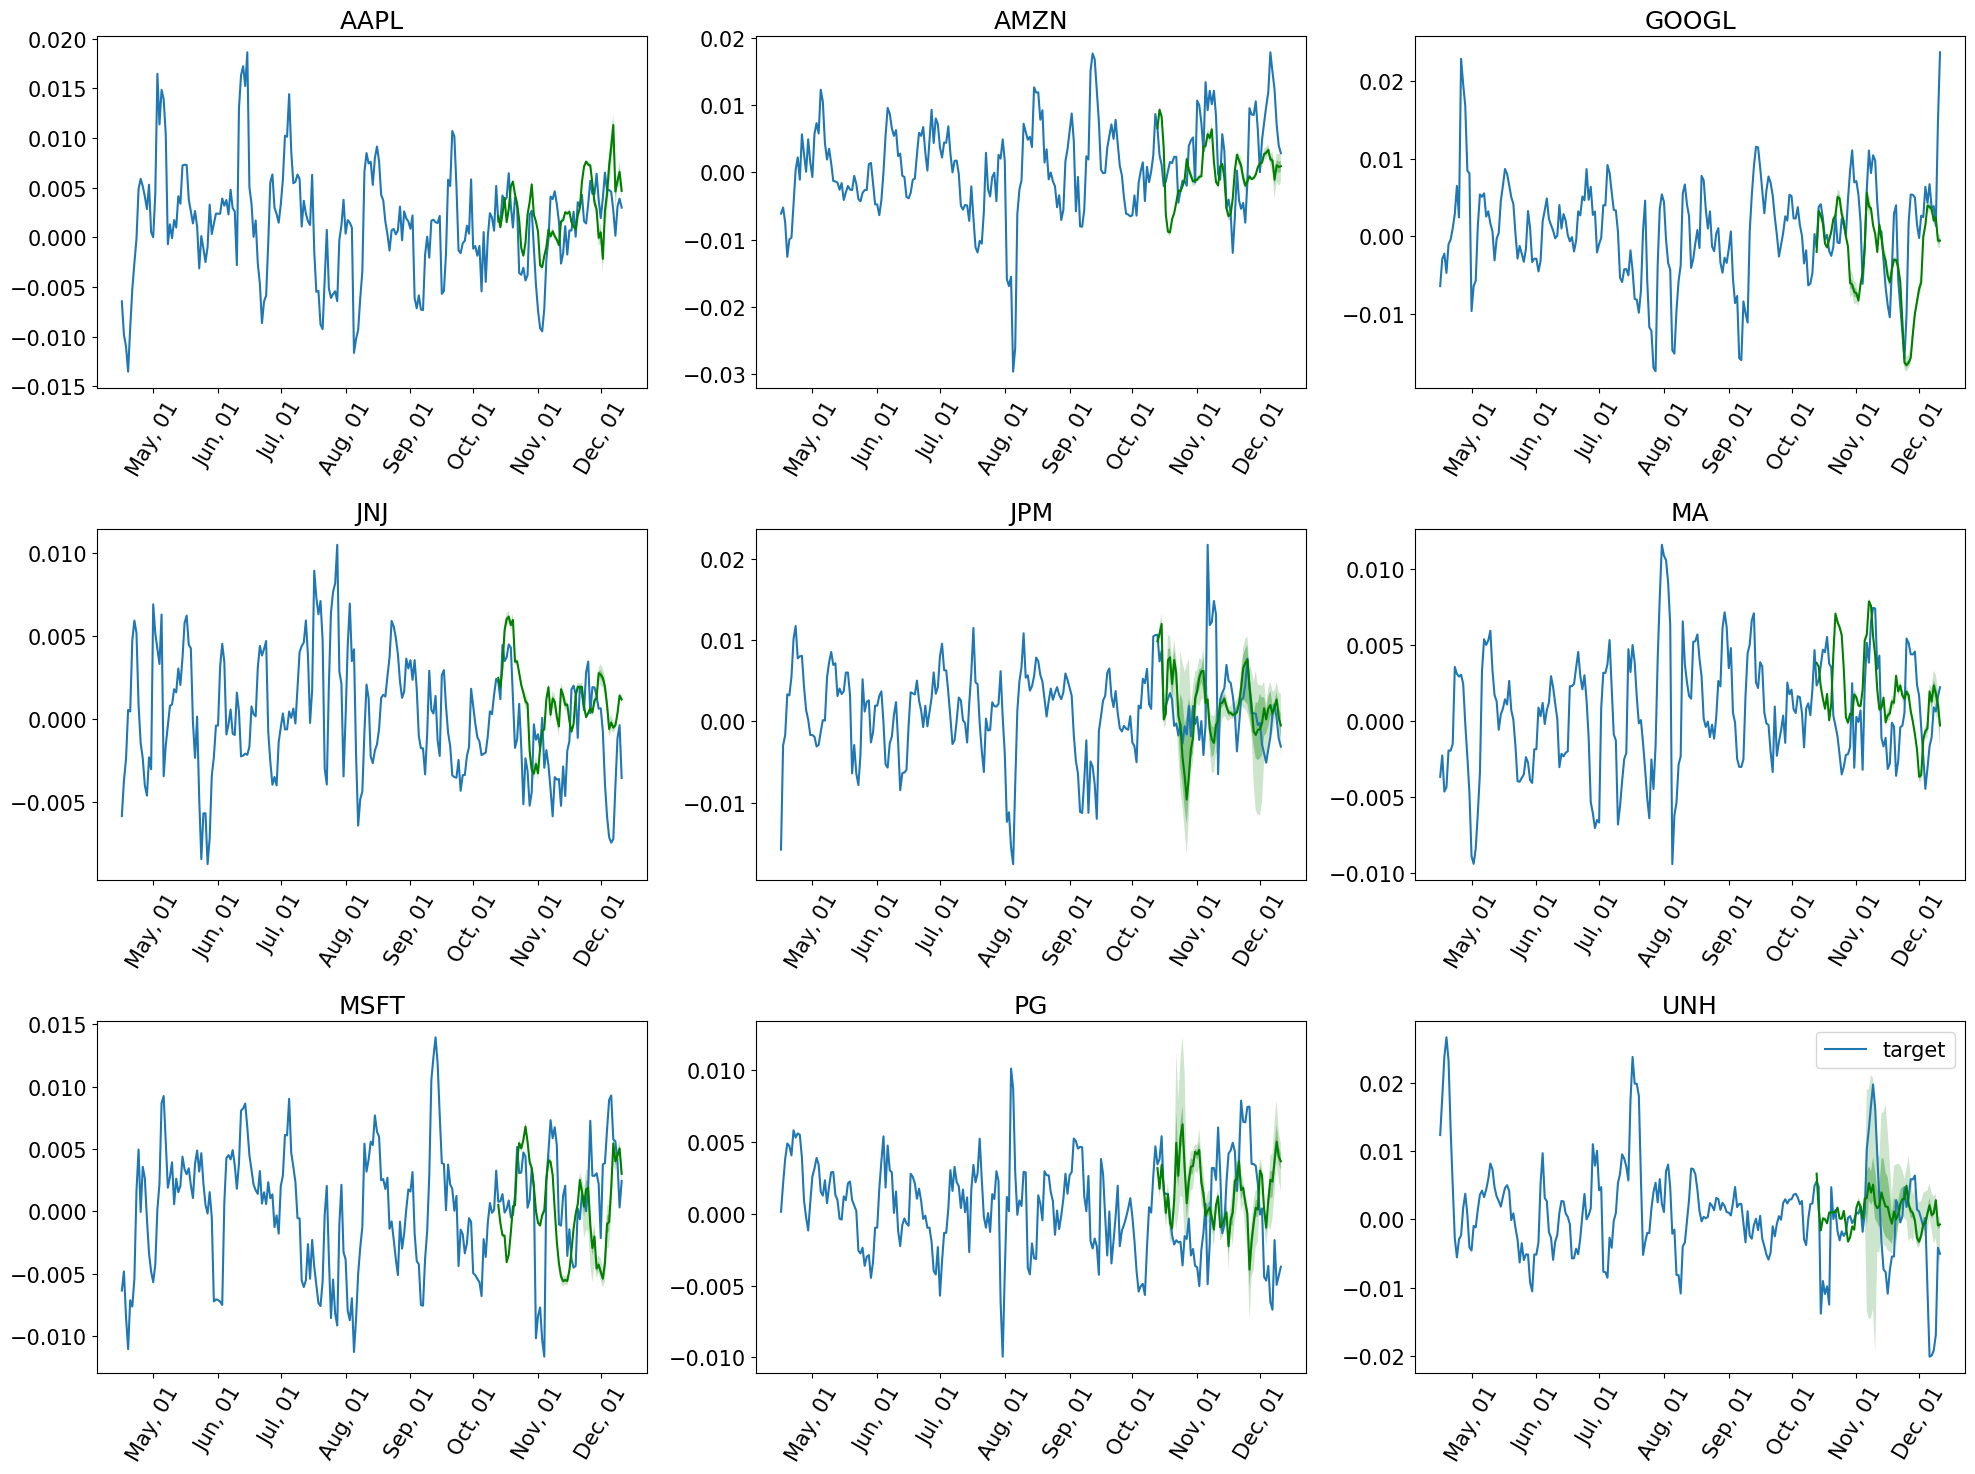

Running evaluation: 10it [00:00, 373.16it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 1.0135935022436473
WQL: 0.9841281758667146
MSE: 3.3309099089819936e-05
MAPE: 3.0118758265177403
RMSE: 0.005771403563243515
MASE: 1.677473778960777


In [15]:
path = "./lightning_logs/version_6/checkpoints/epoch=49-step=2500.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset, prediction_length=prediction_length, device=device,\
                                                             use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

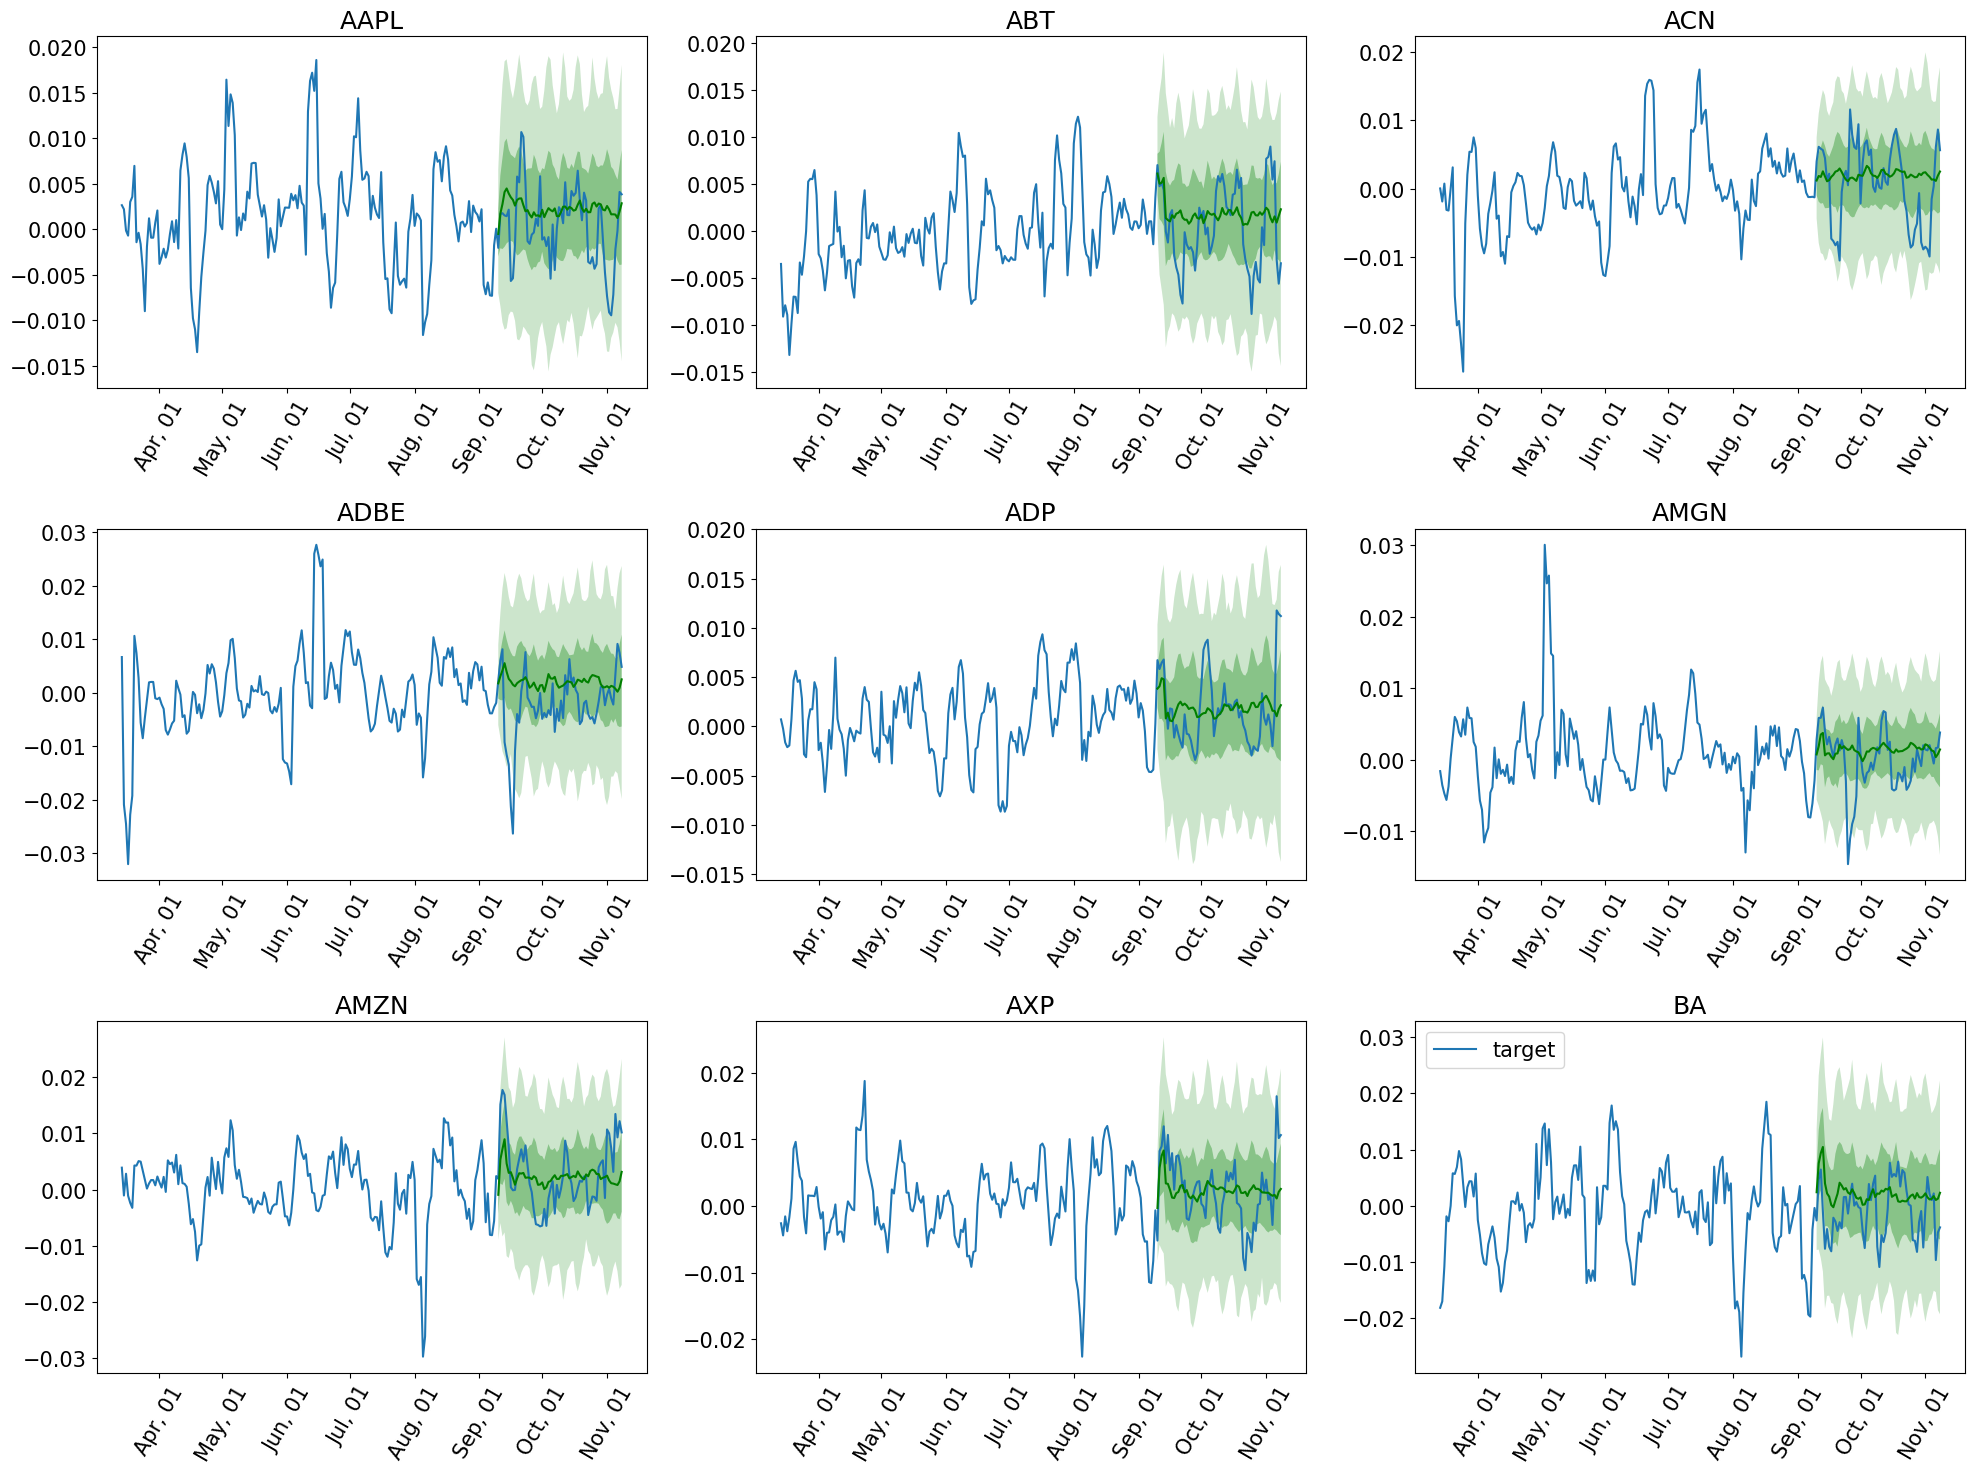

Running evaluation: 10it [00:00, 191.72it/s]


CRPS: 0.8336563830372943
WQL: 0.6030152363365111
MSE: 2.7378013182897124e-05
MAPE: 2.5959186681111652
RMSE: 0.005232400327086712
MASE: 1.3500444254224946


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [13]:
path = "./lightning_logs/version_1/checkpoints/epoch=49-step=2500.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset_2, prediction_length=prediction_length, device=device,\
                                                             use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

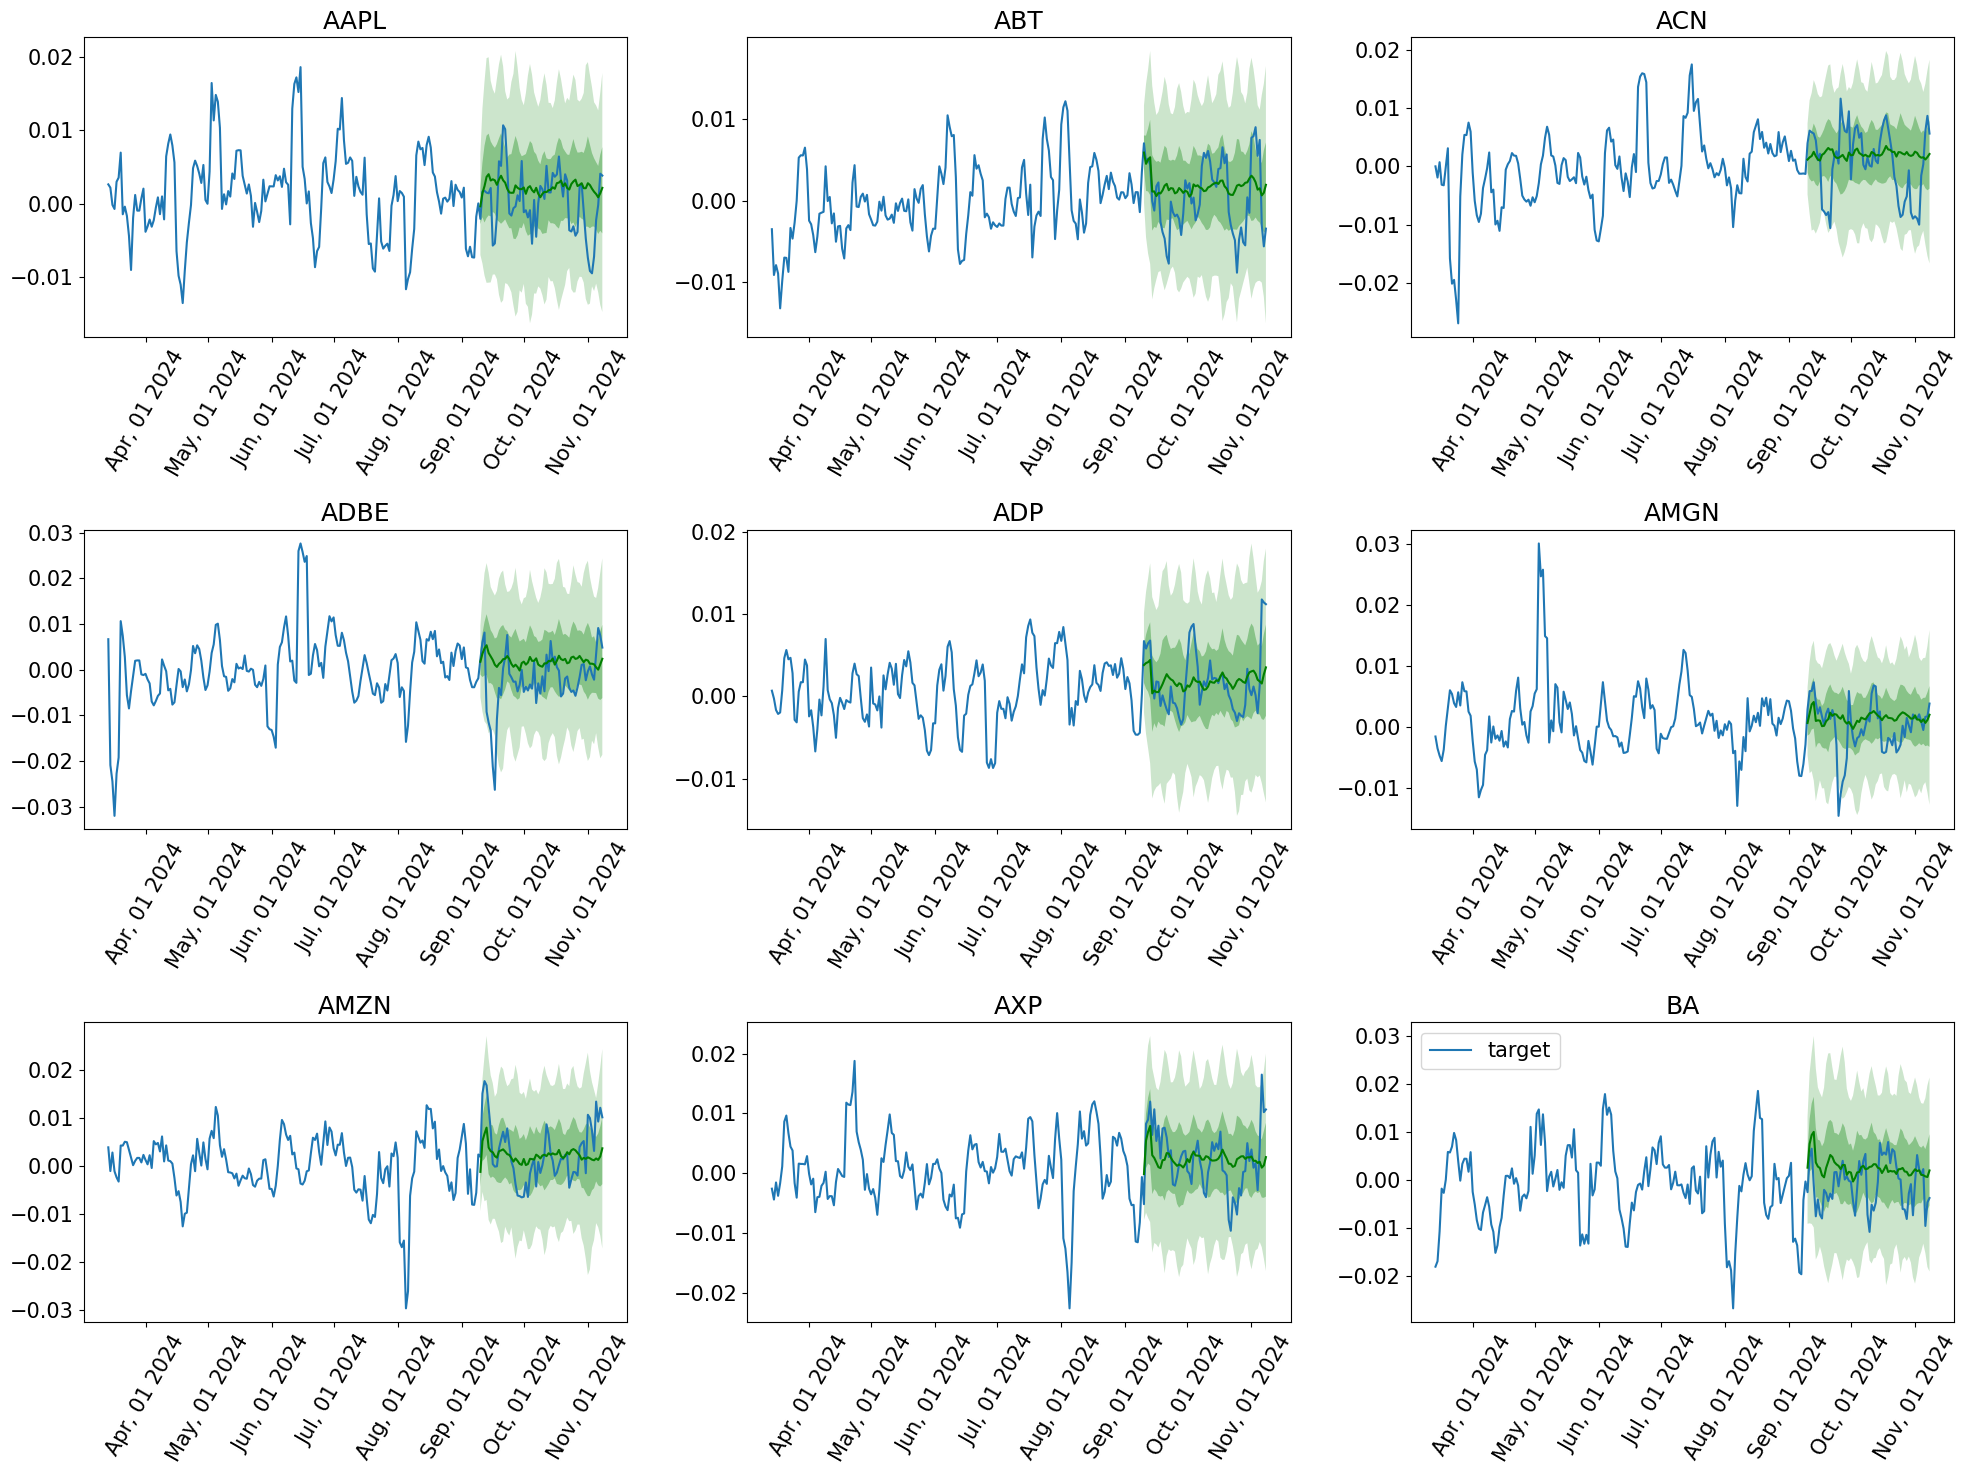

Running evaluation: 10it [00:00, 274.46it/s]


CRPS: 0.8344389721067267
WQL: 0.6078196797717784
MSE: 2.7661751470683763e-05
MAPE: 2.71828842163086
RMSE: 0.005259444026765925
MASE: 1.3449216070642651


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [8]:
path = "./lightning_logs/nocosine/checkpoints/epoch=49-step=2500.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset_2, prediction_length=prediction_length, device=device,\
                                                             use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d %Y")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

In [10]:
print(forecasts_it)

[gluonts.model.forecast.SampleForecast(info=None, item_id='AAPL', samples=array([[ 0.00027435, -0.00039755,  0.00807788, ..., -0.00898062,
        -0.00543952,  0.00058977],
       [ 0.00553292,  0.00251751,  0.00234348, ...,  0.00581954,
         0.00547958,  0.00875306],
       [ 0.00164022,  0.0055105 ,  0.00911546, ...,  0.01017178,
        -0.0013893 , -0.00082524],
       ...,
       [-0.00146218, -0.00092789,  0.00397292, ...,  0.00721878,
         0.00742498,  0.00278338],
       [ 0.00164026,  0.01322526,  0.01058441, ..., -0.00294726,
         0.00036632,  0.00074364],
       [-0.0019733 ,  0.00033924,  0.00658372, ...,  0.00916662,
         0.0069822 ,  0.01069205]], dtype=float32), start_date=Period('2024-09-10', 'D')), gluonts.model.forecast.SampleForecast(info=None, item_id='ABT', samples=array([[ 0.01099883,  0.0098198 ,  0.00919029, ..., -0.00503612,
        -0.00873153, -0.01472651],
       [ 0.00280651,  0.00300041,  0.00439679, ...,  0.00231149,
         0.00500766, 

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

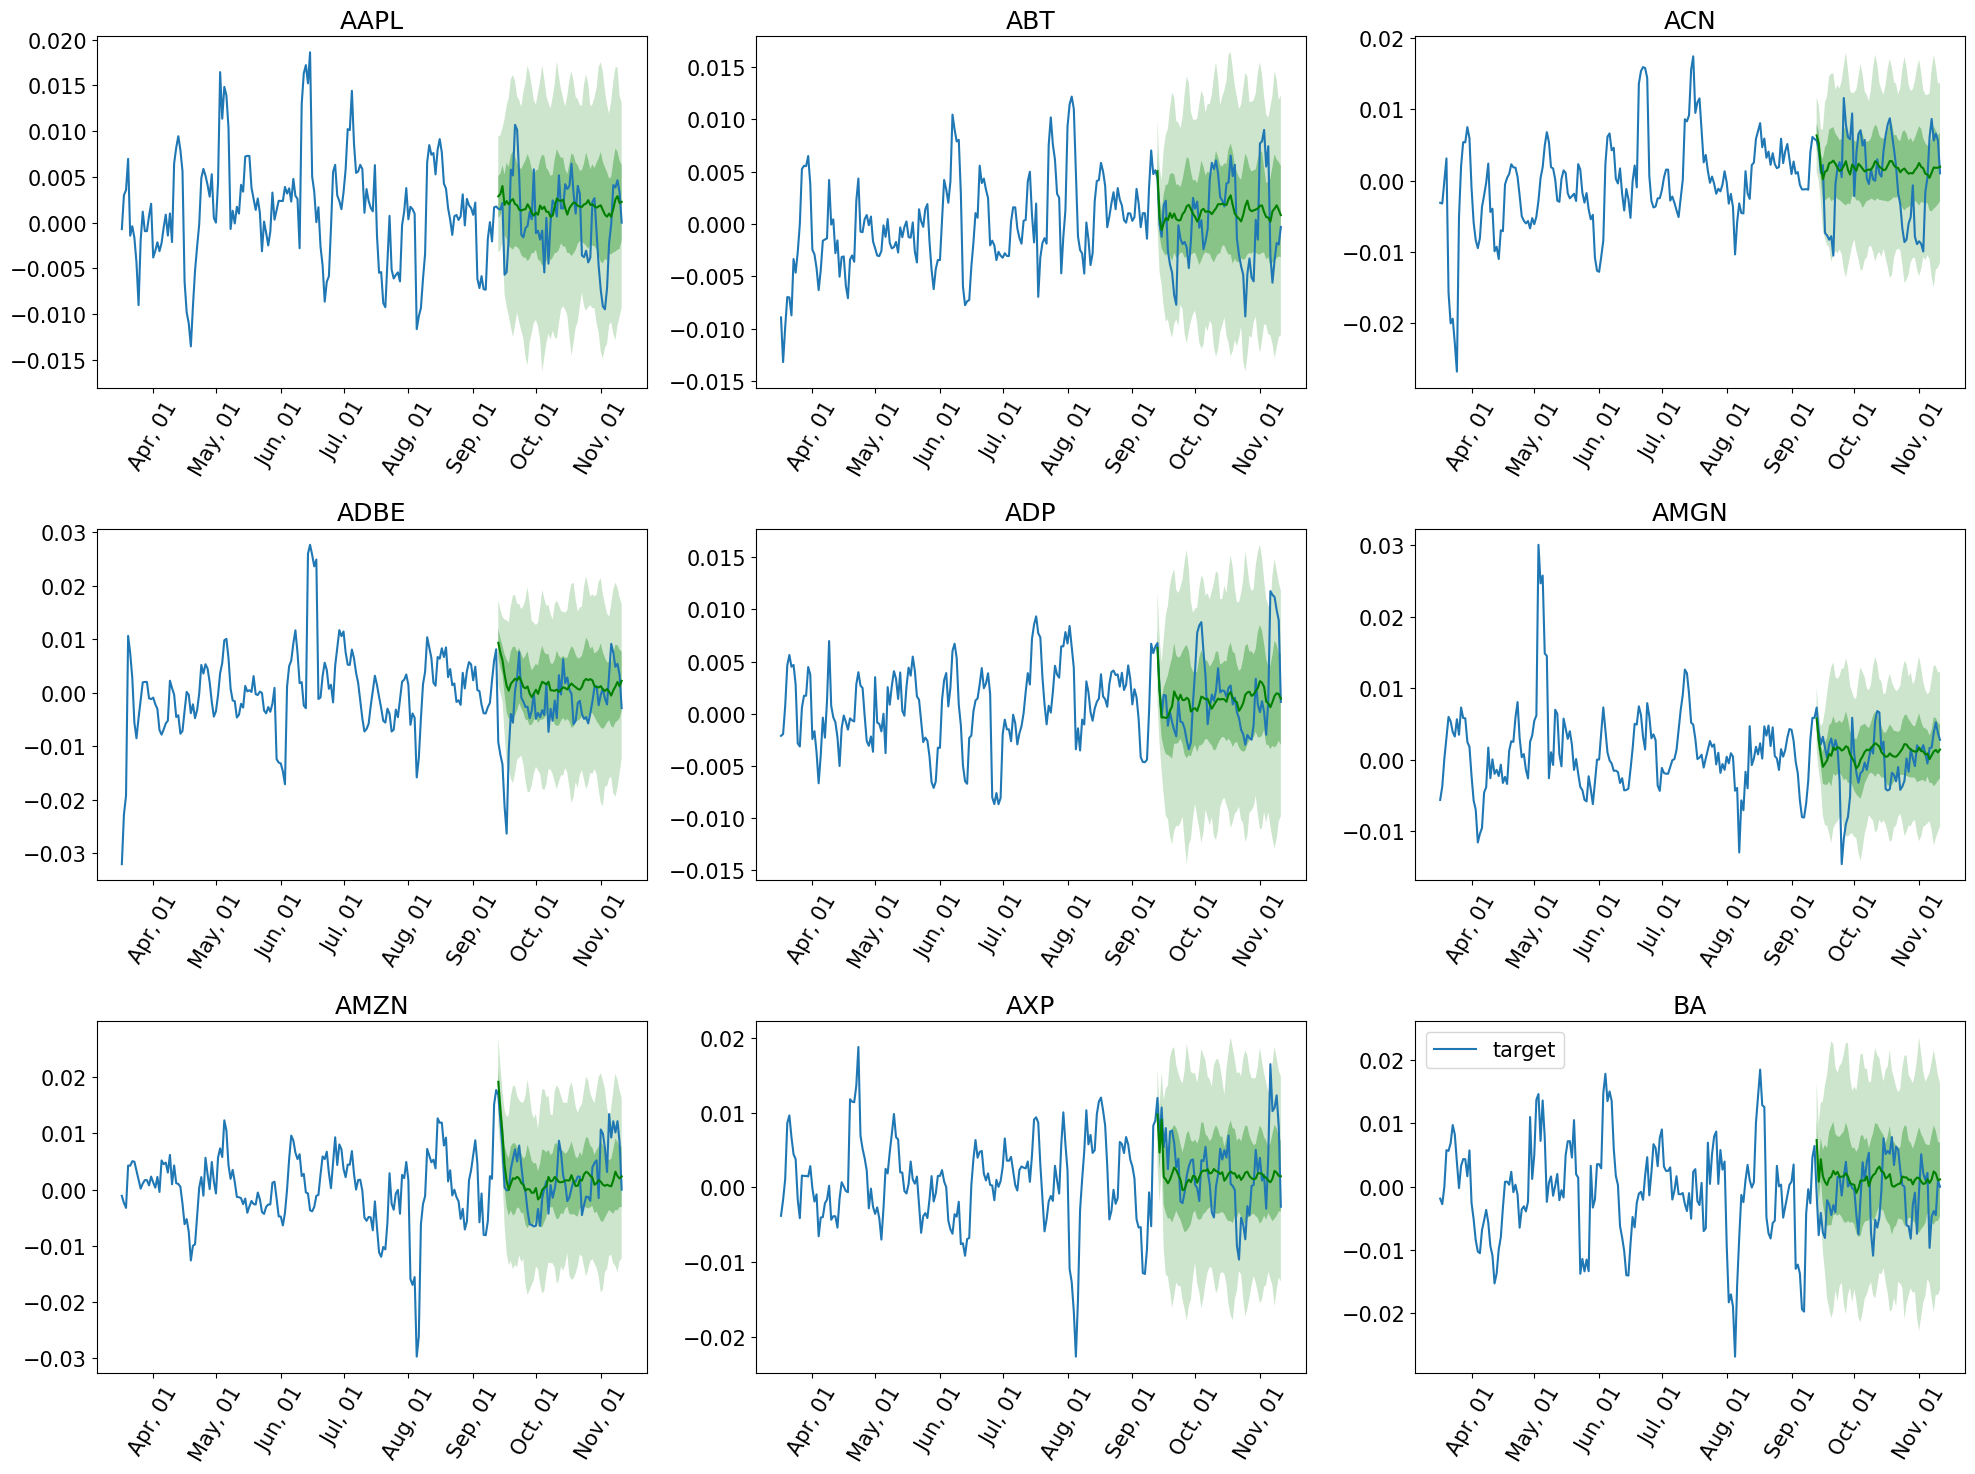

Running evaluation: 10it [00:00, 278.19it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.8254259744164744
WQL: 0.5660425420129979
MSE: 2.7663860431251424e-05
MAPE: 2.0406938059316513
RMSE: 0.0052596445156732246
MASE: 1.3181807296186283


In [8]:
path = "./lightning_logs/version_4/checkpoints/epoch=49-step=2500.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset_2, prediction_length=prediction_length, device=device,\
                                                             use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])